In [43]:
import matplotlib
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
import numpy as np
import pickle as pkl
import cv2
from Dataloader import Dataloader
from src.Vision import Vision
from src.DepthTracker import DepthTracker
from tqdm import tqdm
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# dl = Dataloader('/home/nic/ms-work/dtplayground/new_ex_occ4/','new_ex_occ4')
particleN = 1000
particleCov = np.diag([.01,.01,.01,.001,.001,.001])
dl = Dataloader('/home/nic/ms-work/dtplayground/bear_front/')
bbox,_ = dl.getBbox(0)
# static camera
T = np.array([0,0,0])
R = np.eye(3)

dt = DepthTracker(dl.K,particleN,particleCov)
deltaT = 1/30.0
print(dl.numOfFrames)

295


In [69]:
bestP = []
gtP = []
error=0
lastIdx = 0
for i in tqdm(range(dl.bboxes.shape[0])):
    scanFrame = False
    if i==0:
        scanFrame = True
        xyz = dl.getXYZ(i)
    # if i < 120:
    #     xyz = dl.getXYZ(i)
    else:
        xyz = np.empty((480,640,3))
        xyz[:,:,:] = np.nan
    img = dl.getRGB(i)
    bbox,_ = dl.getBbox(i)
    bestParticle,idx = dt.updateMeasurements(img,xyz,bbox,T,R,deltaT,scanFrame)

    if bestParticle is not None:
        gt_xyz = dl.getXYZ(i)
        lastIdx = idx
        u,v = dt.vision.getBBoxCenter(bbox[0])
        gt_origin = gt_xyz[u,v,:]
        bestP.append(bestParticle)
        gtP.append(gt_origin)
        error += np.linalg.norm(bestParticle[:3]-gt_origin)
    else:
        bestP.append(dt.particleFilter.particles[lastIdx])

100%|██████████| 281/281 [00:09<00:00, 30.45it/s]


0.1233193685273995


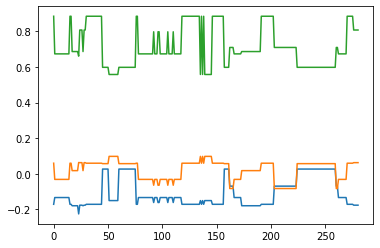

In [70]:
print(error/dl.bboxes.shape[0])
bestP = np.array(bestP)
plt.plot(bestP[:,:3])

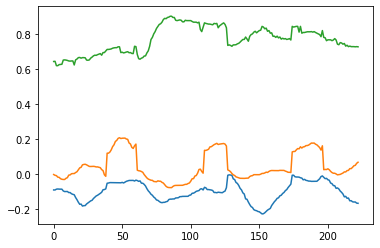

In [71]:
gtP = np.array(gtP)
plt.plot(gtP)#-bestP[:,:3])


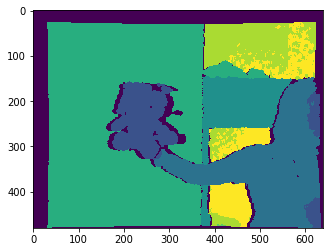

In [12]:
plt.imshow(dl.getDepth(0))

In [19]:
np.max(dl.getDepth(0))

0.248

In [31]:
depthname = '/home/nic/ms-work/dtplayground/bear_front/depth/d-0-1.png'
depth = cv2.imread(depthname,-1)
depth = (depth >> 3) | (depth << (16 - 3))
depth=depth/1000

In [32]:
np.max(depth)

2.101

In [57]:
np.diag(np.array([0.1,0.001,1]))

array([[0.1  , 0.   , 0.   ],
       [0.   , 0.001, 0.   ],
       [0.   , 0.   , 1.   ]])

In [56]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])